In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier

# Data Cleaning 

In [2]:
ds = pd.read_csv('AirBnB_San_Fransico_California_Listings.csv')
ds = ds[~ds['id'].isnull()]

In [3]:
column_with_missing_data = Counter()
for i in ds.columns:
    if len(ds[ds[i].isnull()])!=0:
        column_with_missing_data[i]=len(ds[ds[i].isnull()])/len(ds)
        
    

In [4]:
column_with_missing_data

Counter({'name': 0.0020006668889629878,
         'host_id': 0.00033344448149383126,
         'host_name': 0.003334444814938313,
         'neighbourhood_group': 1.0,
         'neighbourhood': 0.003334444814938313,
         'latitude': 0.0016672224074691564,
         'longitude': 0.002334111370456819,
         'room_type': 0.0020006668889629878,
         'price': 0.00033344448149383126,
         'last_review': 0.03401133711237079,
         'reviews_per_month': 0.03401133711237079})

In [5]:
ds = ds.drop('neighbourhood_group', axis = 1)

## Cleaning Room Type Missing Values 
### Logic: Since the name contains a short description of the accomodation, we could infer what type of room each listing has

In [6]:
ds[ds.room_type.isnull()]

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
22,21334.0,Studio loft on top of Russian Hill,81455.0,Joe,Nob Hill,37.79580,-122.41533,NaN,125,30.0,119.0,2/5/2019,1.06,1.0,348.0
109,80394.0,Hideaway in the Haight,126930.0,Abla,Haight Ashbury,37.77065,-122.44252,NaN,140,30.0,20.0,7/29/2019,0.30,1.0,135.0
394,644091.0,Expansive Bay View Condo,3168113.0,Lee,North Beach,37.80329,-122.40708,NaN,350,3.0,28.0,11/18/2018,0.34,1.0,187.0
1870,7726184.0,Lovely 2 Bedroom,4097204.0,William,Inner Richmond,37.77960,-122.47004,NaN,275,2.0,16.0,10/23/2016,0.33,1.0,0.0
1930,8033268.0,Downtown Union Sq TS/Hotel Studio,6346492.0,Dana,Downtown/Civic Center,37.78846,-122.41054,NaN,180,2.0,5.0,10/8/2016,0.11,29.0,0.0
2004,8464365.0,Spacious room in a Noe Valley condo with a view,2846262.0,Sergio,Noe Valley,37.75148,-122.44182,NaN,95,1.0,20.0,7/27/2019,1.83,3.0,147.0


In [7]:
ds.room_type.unique().tolist()

['Entire home/apt', 'Private room', nan, 'Shared room']

In [8]:
ds.loc[22,'room_type'] = 'Entire home/apt'
ds.loc[109,'room_type'] = 'Entire home/apt'
ds.loc[394,'room_type'] = 'Entire home/apt'
ds.loc[1870,'room_type'] = 'Entire home/apt'
ds.loc[1930,'room_type'] = 'Entire home/apt'
ds.loc[2004,'room_type'] = 'Private room'


## Cleaning Longitude Lattitude Missing Values 
### Logic: based on the neighbourhood (which is another geographic indicator), we would assign the listing the mean value of the lattitude and longitude in the neighbourhood 
### Function Used: lattitude_longitude
#### I. Arguement: dataframe, variables you would like to fill (longitude, lattitude) 
#### II. Goal: fill in the missing value based on the logic above

In [9]:
def lattitude_longitude (df,variable):
    list_missing = df[df[variable].isnull()].neighbourhood.unique()
    for i in list_missing:
        value = df.loc[(ds.neighbourhood== i)&(df[variable].notnull())][variable].unique().mean()
        df.loc[(ds.neighbourhood== i) & (df[variable].isnull()),variable] = value
    
    

In [10]:
lattitude_longitude(ds,'longitude')

In [11]:
lattitude_longitude(ds,'latitude')

## Cleaning neighbourhood missing values
### Logic: neighbourhood is defined based on the geographic location, hence we could use longitude and lattitude as features and KNN to impute the values
### Function Used
#### I. Argument: dataframe, number of features used to perform KNN model, the feature you would like to predict
#### II. goal: perform logic II to fill in missing values

In [12]:
def knn_impute(df, feature_list, predicted_feature):
    train_x = df[df[predicted_feature].notnull()][feature_list]
    train_y = df[df[predicted_feature].notnull()][predicted_feature]
    
    test_x = df[df[predicted_feature].isnull()][feature_list]
    clf = KNeighborsClassifier(3, weights='distance')
    trained_model = clf.fit(train_x, train_y)
    imputed_values = trained_model.predict(test_x)
    
    n = -1
    for index, row in pd.DataFrame(df[df[predicted_feature].isnull()][predicted_feature]).iterrows():
        n +=1
        df.loc[index,predicted_feature] = imputed_values[n]
    

In [13]:
knn_impute(ds,['longitude','latitude'],'neighbourhood')

## Cleaning price missing values
### Logic I: There are also price that are listed as string, we need to convert them into numerical formt
### Logic II: Since price is also similar in the same longitude,lattitude, we could use the function before to impute the missing value

In [14]:
knn_impute(ds,['longitude','latitude'],'price')

In [15]:
for index, content in ds[pd.to_numeric(ds['price'],errors='coerce').isnull()].iterrows():
    
    ds.loc[index,'price']=content['price'][1]+content['price'][2]

## Cleaning Data Type 
### Logic: there are certain numeric columns that need to be converted to more specific datatype

In [16]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2999 entries, 0 to 2998
Data columns (total 15 columns):
id                                2999 non-null float64
name                              2993 non-null object
host_id                           2998 non-null float64
host_name                         2989 non-null object
neighbourhood                     2999 non-null object
latitude                          2999 non-null float64
longitude                         2999 non-null float64
room_type                         2999 non-null object
price                             2999 non-null object
minimum_nights                    2999 non-null float64
number_of_reviews                 2999 non-null float64
last_review                       2897 non-null object
reviews_per_month                 2897 non-null float64
calculated_host_listings_count    2999 non-null float64
availability_365                  2999 non-null float64
dtypes: float64(9), object(6)
memory usage: 454.9+ KB


In [17]:
ds['price']= pd.to_numeric(ds['price'])
ds['last_review'] = pd.to_datetime(ds['last_review'])

## Cleaning Extreme Values
### Logic: looking at the extreme value across all the continuous variables
#### Findings: the extreme value for minimum_nights stands out as it is more than 3 years which does not seem logical for airbnb 

In [18]:
ds.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,2.999000e+03,2.998000e+03,2999.000000,2999.000000,2999.000000,2.999000e+03,2999.000000,2897.000000,2999.000000,2999.000000
mean,6.155475e+06,1.549547e+07,37.765094,-122.431272,225.354451,3.336011e+04,87.085695,1.693555,4.815605,159.329110
std,4.838002e+06,2.045042e+07,0.021934,0.025667,326.495083,1.826046e+06,102.376428,1.827293,12.233129,133.589202
min,9.580000e+02,1.000000e+00,37.708280,-122.513060,29.000000,1.000000e+00,0.000000,0.010000,1.000000,0.000000
25%,1.578950e+06,1.720046e+06,37.750770,-122.442830,108.000000,2.000000e+00,12.000000,0.300000,1.000000,22.000000
50%,5.253001e+06,6.641773e+06,37.763850,-122.427310,155.000000,3.000000e+00,48.000000,1.020000,1.000000,136.000000
75%,1.019669e+07,2.156597e+07,37.782670,-122.412525,250.000000,3.000000e+01,126.000000,2.530000,3.000000,295.000000
max,1.546892e+07,9.927078e+07,37.810310,-122.370940,9999.000000,1.000000e+08,730.000000,15.790000,254.000000,365.000000


In [19]:
ds.drop(ds[ds.minimum_nights==ds.minimum_nights.max()].index, inplace = True)

# Data Visualization
## Categorical Variables: neighbourhood, room_type
### 1) neighbourhood has too many categories
### 2) room_type has three categories

## Continuous Variables: price, minimum_nights, number_of_reviews, reviews_per_month, calculated_host_listings_count, availability_365
### 1) price is the feature of attention 
### 2) other continuous variables will help explain differences in price <br>

### Graph 1: price distribution
### Takeaway: most listings have price around 200

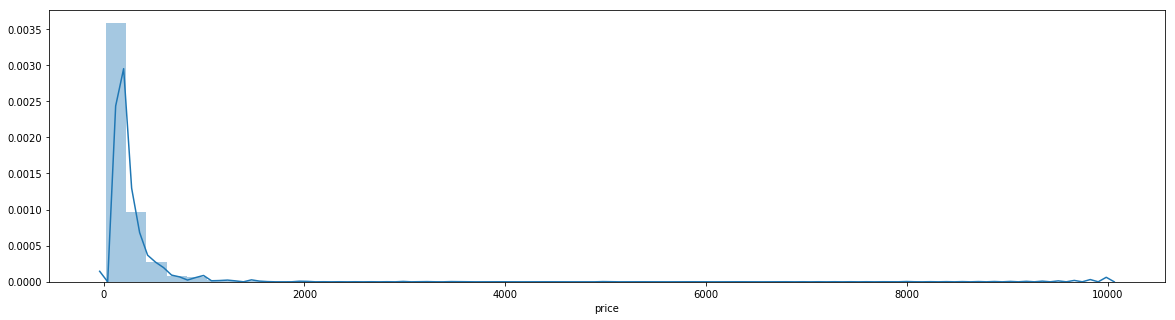

In [20]:
plt.figure (figsize=(20,5))
sns.distplot(ds['price'], hist=True, kde=True)

### Graph 2: listings across different room_type
### Takeaway: there are more listings under 'Entire home/apt' and least number of listings under 'Shared room'

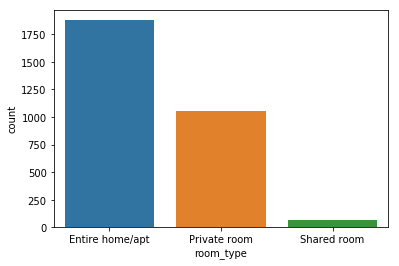

In [21]:
sns.countplot(x='room_type',data=ds)

### Graph 3: price distribution across different room_type 
### Takeaway: there is slight difference in price across these three room types and 'Entire home/apt' has more listings and yet most prices fall under 2000

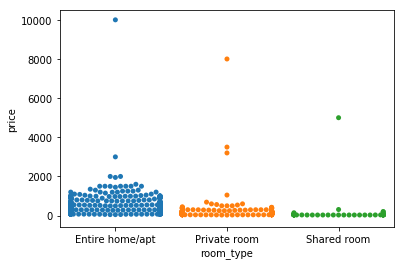

In [22]:
sns.swarmplot(x='room_type', y='price', data=ds)

### Graph 4: Regression plot between availability_365 and number_of_reviews across different room_type
### Takeaway: while for "Entire home/apt", "Private room" there are no clear correlations, there is a negative correlation between number of reviews and availability_365 for shared room 

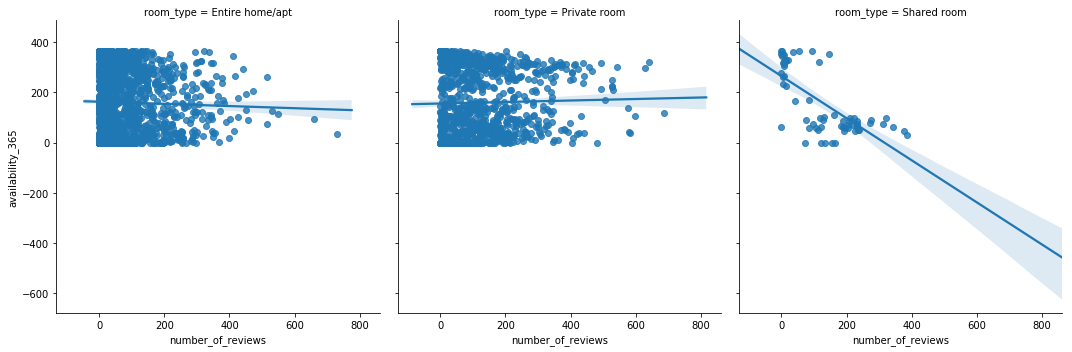

In [23]:
sns.lmplot(y='availability_365',x='number_of_reviews',data=ds,col="room_type")

### Graph 5: Regression plots between 'availability_365' and 'price' across different room types
### Takeaway: there is no significant correlation 

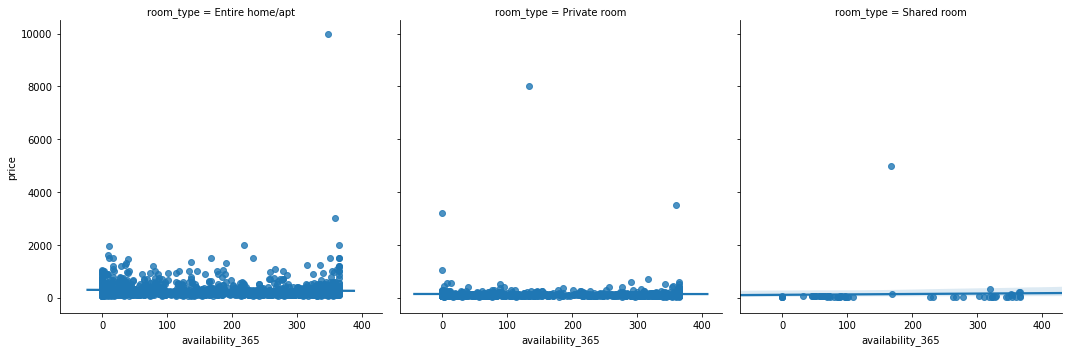

In [24]:
sns.lmplot(y='price',x='availability_365',data=ds,col="room_type")

### Graph 6: Regression plots between 'minimum_nights' and 'price' across different room types
### Takeaway: there is no significant correlation 

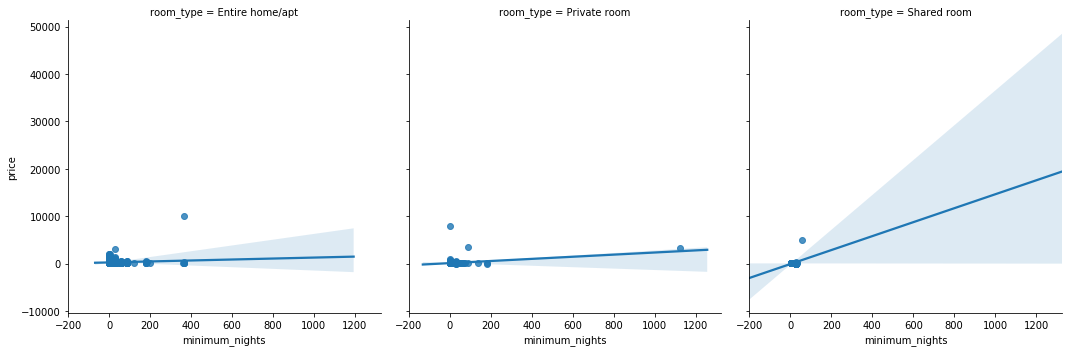

In [25]:
sns.lmplot(y='price',x='minimum_nights',data=ds,col="room_type")

### Graph 7: Regression plots between 'calculated_host_listings_count' and 'price' across different room types
### Takeaway: there is no significant correlation 

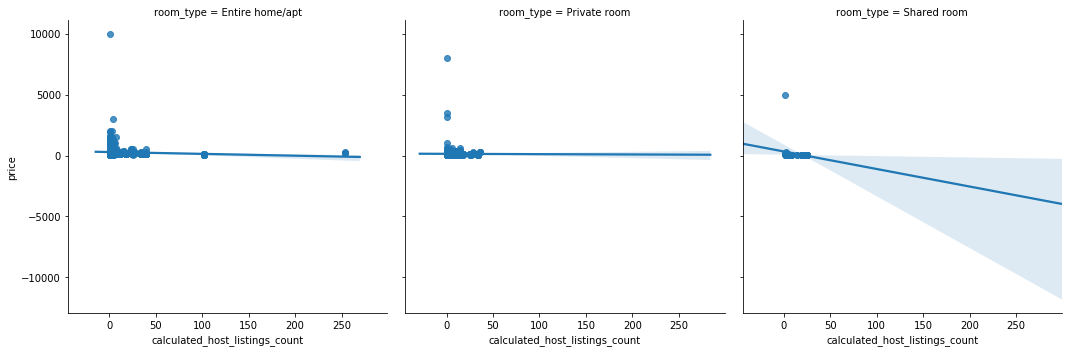

In [26]:
sns.lmplot(y='price',x='calculated_host_listings_count',data=ds,col="room_type")

### Graph 8: Regression plots between 'reviews_per_month' and 'price' across different room types
### Takeaway: there is no significant correlation 

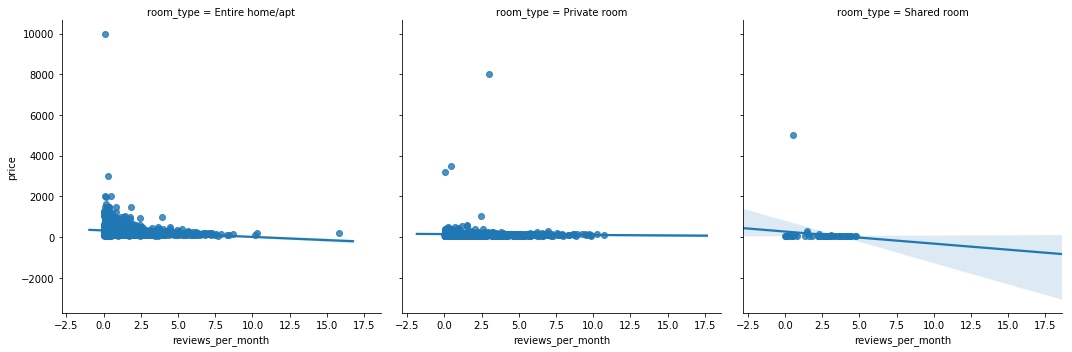

In [27]:
sns.lmplot(y='price',x='reviews_per_month',data=ds,col="room_type")

### Graph 9: a group of plots that indicate the top 10 neighborhoods for each room type 
### Function Used: 
#### I. Argument: specified dataset (room_type)
#### II. Goal: plot the top 10 concentrated neighbourhood where specified room_type has listings in
### Takeaway: The number of listings spread evenly across the top 10 for private room and entire apartment but concentrate on the top 5 for shared room 

In [28]:
def plot_top_5_neighrbourhood_count(dataset):
    neighbour_shared = Counter()
    for i in dataset.neighbourhood.unique().tolist():
        neighbour_shared[i] = len(dataset[dataset.neighbourhood == i])

    neighbour_shared = pd.DataFrame.from_dict(neighbour_shared,orient='index')
    neighbour_shared.columns = ['count']
    neighbour_shared.sort_values(by=['count'],ascending=False,inplace = True)    

    plt.figure (figsize=(50,7))
    sns.barplot(x=neighbour_shared.index[0:10],y=neighbour_shared['count'][0:10])


In [29]:
ds_pri = ds[ds.room_type == 'Private room']
ds_shared = ds[ds.room_type == 'Shared room']
ds_entire = ds[ds.room_type == 'Entire home/apt']

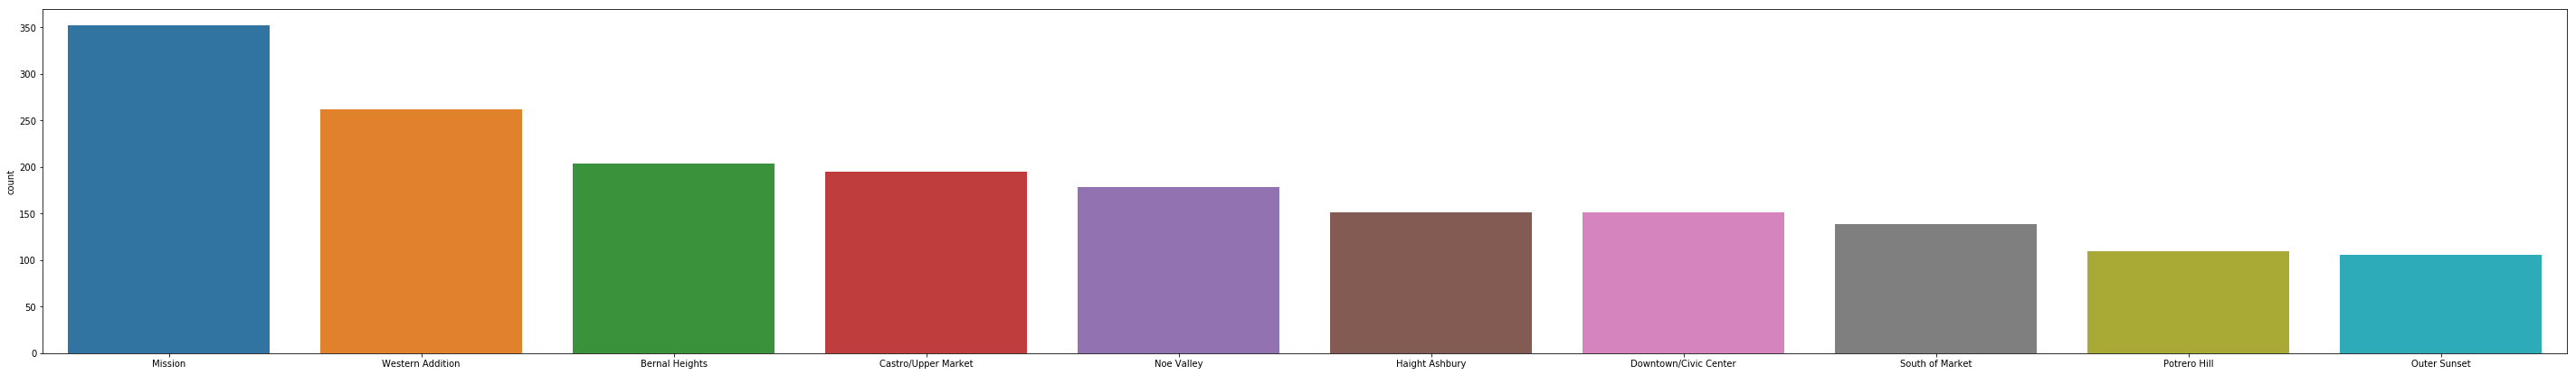

In [30]:
plot_top_5_neighrbourhood_count(ds)

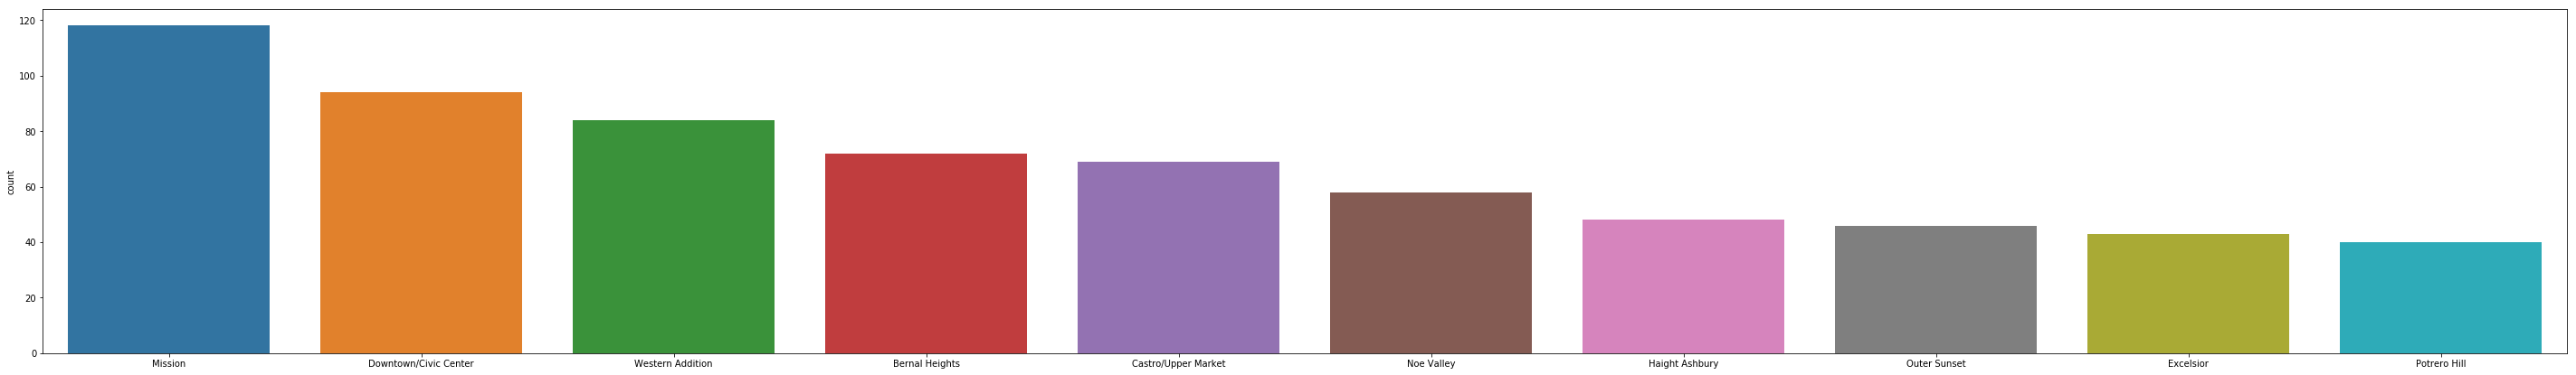

In [31]:
plot_top_5_neighrbourhood_count(ds_pri)

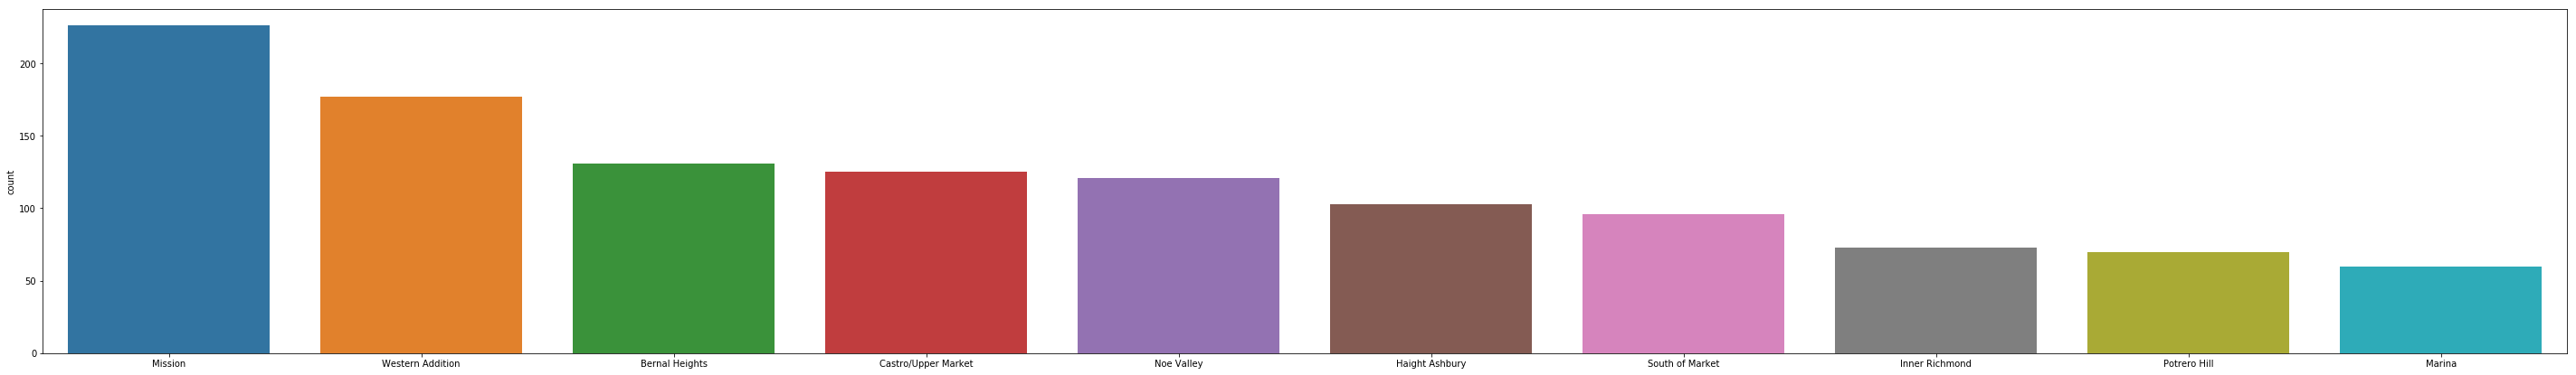

In [32]:
plot_top_5_neighrbourhood_count(ds_entire)

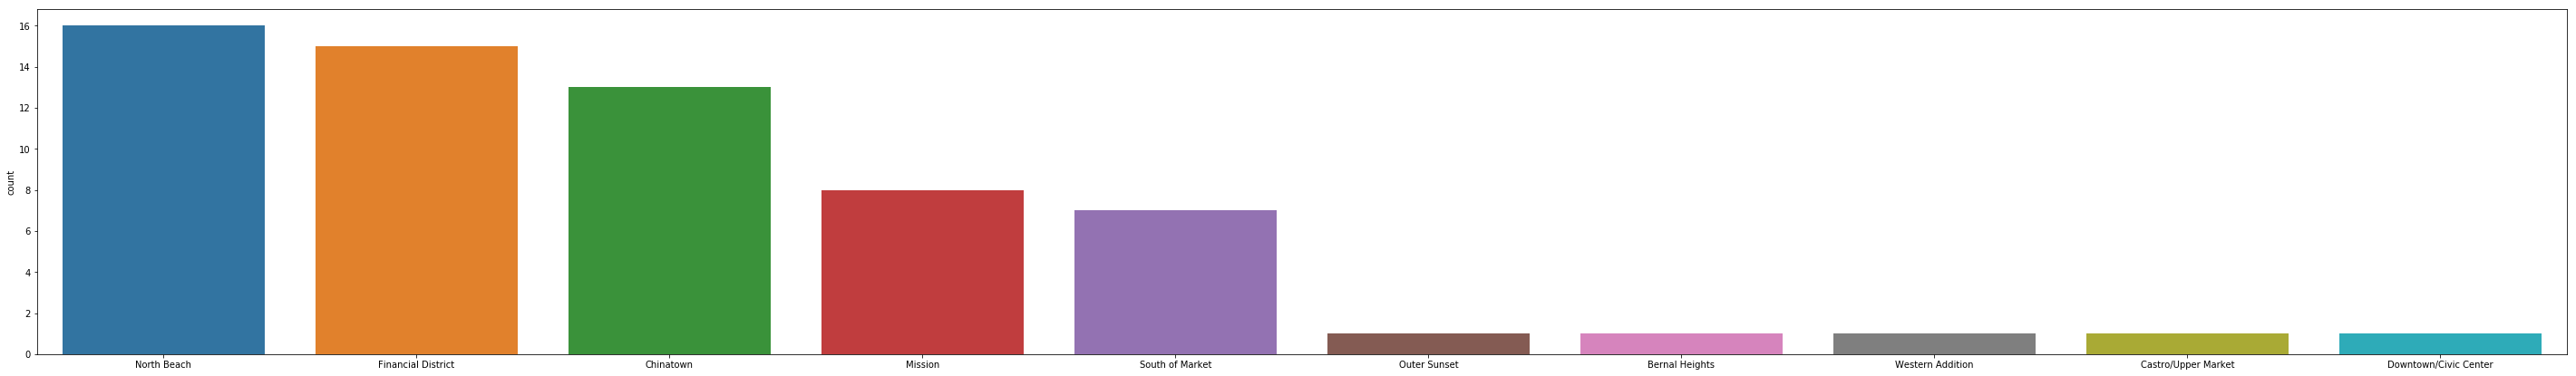

In [33]:
plot_top_5_neighrbourhood_count(ds_shared)

### Graph 10: price distribution across some interesting top neighborhoods

In [34]:
list_of_interesting_neighbourhood = ['North Beach','Financial District','Bernal Heights','Noe Valley','Chinatown','Mission','Western Addition','Castro/Upper Market',]
ds_interesting = ds[ds.neighbourhood.isin(list_of_interesting_neighbourhood)]

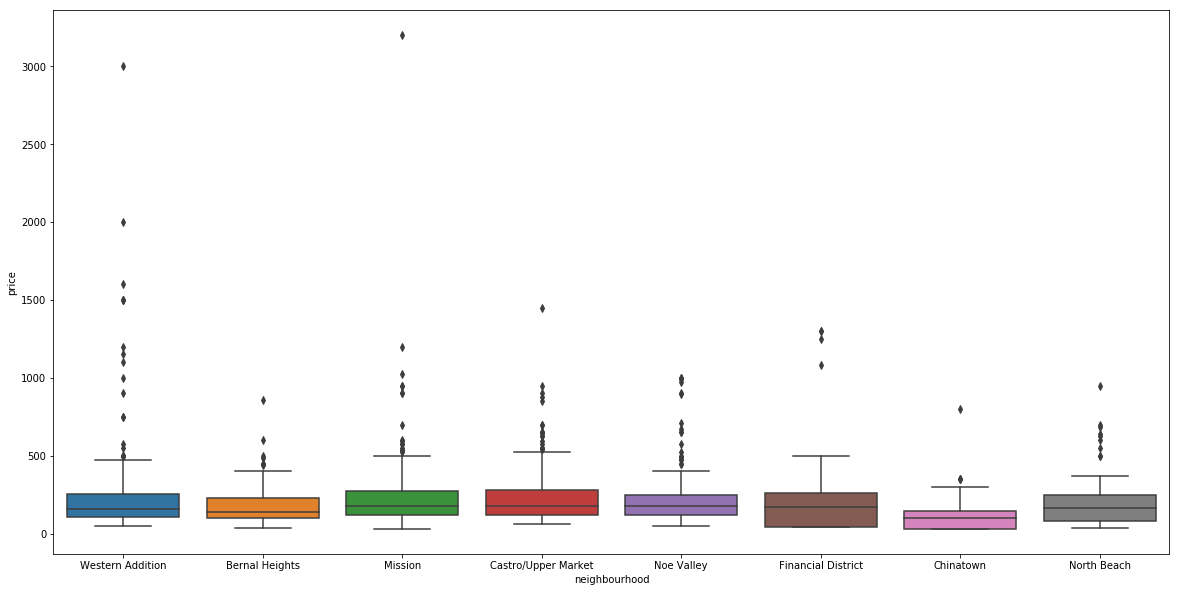

In [35]:
plt.figure (figsize=(20,10))
sns.boxplot(x='neighbourhood',y='price',data=ds_interesting)